# Projet 7 : Implémentez un modèle de scoring

Notebook de traitement des données et de création du modèle de prédiction de solvabilité des clients.


# Summary
 - <a href="#C1">Import and settings</a>
    - <a href="#C1.1">Import required items</a>
    - <a href="#C1.2">Settings and assumptions</a>
 - <a href="#C2">Functions</a>
 - <a href="#C3">Data analysis and cleaning</a>
    - <a href="#C3.1">Overview</a>
    - <a href="#C3.2">Cleaning</a>
 - <a href="#C4">Prediction model</a>
    - <a href="#C4.1">Select features</a>
    - <a href="#C4.2">Find the best model</a>
    - <a href="#C4.3">Fine-tuning</a>
    - <a href="#C4.4">Features importance</a>

# <a name="C1"> Import and settings
## <a name="C1.1"> Import required items

In [1]:
# Use code formatting tool
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import required librairies
import datetime
import pickle
import warnings

import pandas as pd
import numpy as np
import random
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, kernel_ridge, metrics
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

import shap

<IPython.core.display.Javascript object>

In [3]:
# Import data from files in DataFrames
path = "Projet+Mise+en+prod+-+home-credit-default-risk/"

data_application_test = pd.read_csv(path + "application_test.csv")

data_application_train = pd.read_csv(path + "application_train.csv")

data_bureau = pd.read_csv(path + "bureau.csv")

data_bureau_balance = pd.read_csv(path + "bureau_balance.csv")

data_credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")

data_col_desc = pd.read_csv(
    path + "HomeCredit_columns_description.csv", encoding="ISO-8859-1", index_col=0
)

data_installments_payments = pd.read_csv(path + "installments_payments.csv")

data_POS_CASH_balance = pd.read_csv(path + "POS_CASH_balance.csv")

data_previous_application = pd.read_csv(path + "previous_application.csv")

data_sample_submission = pd.read_csv(path + "sample_submission.csv")

<IPython.core.display.Javascript object>

## <a name="C1.2"> Settings and assumptions

In [4]:
# Set the results display for dataframes
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = "{:,.4f}".format

# Initialize javascript for shap
shap.initjs()

# Random state
random_set = 11

# Data sizing
n_sample = 20000
test_size = 0.35

# Maximum feature emptiness
max_empty = 0.30

# Features selection
k_features = 20

# SMOTE
k_smote = 5
smote_strategy = 0.85

# Grid search
splits = 5
score = metrics.make_scorer(metrics.fbeta_score, beta=3)
score_name = "f3 score"

# Models
n_alphas = 10
# SVC
Cs = np.logspace(-10, 10, n_alphas)
tolerance = [0.01]
kernel = ["rbf"]
cache_svc = 8000
# Light GBM & GBR & RFC
estimators = range(300, 800, 100)
# Light GBM & GBR
learning_rate = np.arange(0.010, 0.030, 0.005)
# Light GBM & RFC
min_samples_leaf = range(15, 30, 5)
max_trees = [8, 16, 32, None]
# Light GBM
num_leaves = range(20, 40, 5)
# Multi-Layer Perceptron Regressor
alphas = np.logspace(-10, 10, n_alphas)
iteration = range(600, 1400, 200)
layers = range(10, 25, 5)

# feature importance
max_features_display = 10

<IPython.core.display.Javascript object>

# <a name="C2"> Functions

In [5]:
# Function to remove features that has not enough values and replace empty values with mode or median
def clean_df(df):
    """
    Drop columns where the number of values is above the maximum emptiness setting.
    Remainder columns containing empty values are filled with :
     - median value for numeric features
     - mode value for qualitative features

    Parameters
    ----------
    df : DataFrame

    Return
    ------
    Processed DataFrame

    """
    col_to_ignore = df.columns[df.isnull().mean() > max_empty].to_list()
    df = df.drop(col_to_ignore, axis=1)
    col_to_fill = df.columns[df.isnull().mean() > 0].to_list()
    for col in col_to_fill:
        if df[col].dtypes == object:
            df.loc[df[col].isnull(), col] = df[col].mode()[0]
        else:
            df.loc[df[col].isnull(), col] = df[col].median()
    return df

<IPython.core.display.Javascript object>

In [6]:
# Function to manage outliers values thanks to interquartile range
def outliers(df, var):
    """
    For the specified feature, empty values that are far from first and third quartiles using interquartile range method.

    Parameters
    ----------
    df : DataFrame
    var : name of the feature to be processed


    """
    # Calculate first and third quartiles
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    # Calculate interquartile range
    IQ = Q3 - Q1
    # Define minimum and maximum values in order to identify outliers
    mini = Q1 - 1.5 * IQ
    maxi = Q3 + 1.5 * IQ
    # Replace outliers with "NaN"
    mask_mini = df[var] < mini
    df.loc[mask_mini, var] = np.NaN
    mask_maxi = df[var] > maxi
    df.loc[mask_maxi, var] = np.NaN

<IPython.core.display.Javascript object>

# <a name="C3"> Data analysis
## <a name="C3.1"> Overview

In [7]:
# Columns description file
data_col_desc["Table"].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

<IPython.core.display.Javascript object>

In [8]:
# example for the main table
data_col_desc[data_col_desc["Table"] == "application_{train|test}.csv"]

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


<IPython.core.display.Javascript object>

In [9]:
# Is this useful? No
data_sample_submission.describe()

,SK_ID_CURR,TARGET
count,"48,744.0000","48,744.0000"
mean,"277,796.6763",0.5000
std,"103,169.5473",0.0000
min,"100,001.0000",0.5000
25%,"188,557.7500",0.5000
50%,"277,549.0000",0.5000
75%,"367,555.5000",0.5000
max,"456,250.0000",0.5000


<IPython.core.display.Javascript object>

In [10]:
# Is this useful? No
data_application_test.shape

(48744, 121)

<IPython.core.display.Javascript object>

In [11]:
# Overview of the main table we'll be using
data_application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.0000","406,597.5000","24,700.5000","351,000.0000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,"-3,648.0000",-2120,NaN,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,"-1,134.0000",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,"270,000.0000","1,293,502.5000","35,698.5000","1,129,500.0000",Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,"-1,186.0000",-291,NaN,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,"67,500.0000","135,000.0000","6,750.0000","135,000.0000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,"-4,260.0000",-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.5559,0.7296,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,-815.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,100006,0,Cash loans,F,N,Y,0,"135,000.0000","312,682.5000","29,686.5000","297,000.0000",Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.0080,-19005,-3039,"-9,833.0000",-2437,NaN,1,1,0,1,0,0,Laborers,2.0000,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.6504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

<IPython.core.display.Javascript object>

In [12]:
# Overview of the main table we'll be using => there are some empty values
data_application_train.describe(include="all")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,"307,511.0000","307,511.0000",307511,307511,307511,307511,"307,511.0000","307,511.0000","307,511.0000","307,499.0000","307,233.0000",306219,307511,307511,307511,307511,"307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","104,582.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000",211120,"307,509.0000","307,511.0000","307,511.0000",307511,"307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000",307511,"134,133.0000","306,851.0000","246,546.0000","151,450.0000","127,568.0000","157,504.0000","103,023.0000","92,646.0000","143,620.0000",...,"151,450.0000","127,568.0000","157,504.0000","103,023.0000","92,646.0000","143,620.0000","152,683.0000","154,491.0000","98,869.0000","124,921.0000","97,312.0000","153,161.0000","93,997.0000","137,829.0000",97216,153214,"159,080.0000",151170,161756,"306,490.0000","306,490.0000","306,490.0000","306,490.0000","307,510.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","307,511.0000","265,992.0000","265,992.0000","265,992.0000","265,992.0000","265,992.0000","265,992.0000"
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,NaN,TUESDAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Business Entity Type 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reg oper account,block of flats,NaN,Panel,No,NaN,NaN,NaN,NaN,NaN,NaN,Na

<IPython.core.display.Javascript object>

In [13]:
# Let's look at some columns emptiness rate
print(data_previous_application.DAYS_FIRST_DRAWING.isnull().mean())
print(data_previous_application.DAYS_FIRST_DUE.isnull().mean())
print(data_previous_application.DAYS_LAST_DUE_1ST_VERSION.isnull().mean())
print(data_previous_application.DAYS_LAST_DUE.isnull().mean())
print(data_previous_application.DAYS_TERMINATION.isnull().mean())
print(data_previous_application.AMT_DOWN_PAYMENT.isnull().mean())
print(data_previous_application.RATE_DOWN_PAYMENT.isnull().mean())

0.40298129461254667
0.40298129461254667
0.40298129461254667
0.40298129461254667
0.40298129461254667
0.536364801157217
0.536364801157217


<IPython.core.display.Javascript object>

In [14]:
# Let's look at some columns emptiness rate
print(data_bureau.AMT_CREDIT_MAX_OVERDUE.isnull().mean())
print(data_bureau.AMT_CREDIT_SUM_LIMIT.isnull().mean())
print(data_bureau.AMT_ANNUITY.isnull().mean())
data_bureau[~data_bureau.AMT_ANNUITY.isnull()]

0.6551326359159837
0.3447741472406649
0.714734902949614


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
768,380361,5715448,Active,currency 1,-820,0,"31,069.0000",NaN,NaN,0,"67,500.0000",0.0000,"67,500.0000",0.0000,Credit card,-183,0.0000
769,380361,5715449,Active,currency 1,-357,0,"1,119.0000",NaN,NaN,0,"45,000.0000",0.0000,"45,000.0000",0.0000,Credit card,-130,"2,691.0000"
770,380361,5715451,Closed,currency 1,-917,0,-187.0000,-759.0000,NaN,0,"74,439.0000",0.0000,0.0000,0.0000,Consumer credit,-748,0.0000
771,380361,5715452,Closed,currency 1,-993,0,"31,039.0000",-831.0000,NaN,0,"315,000.0000",0.0000,0.0000,0.0000,Credit card,-818,0.0000
772,380361,5715453,Closed,currency 1,-1146,0,681.0000,-780.0000,NaN,0,"2,025,000.0000",0.0000,0.0000,0.0000,Consumer credit,-769,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716285,435426,5053678,Closed,currency 1,-1147,0,-416.0000,-849.0000,0.0000,0,"205,488.0000",0.0000,0.0000,0.0000,Consumer credit,-835,"94,378.5000"
1716286,377669,5053682,Closed,currency 1,-2215,0,"-1,843.0000","-1,653.0000",NaN,0,"58,027.5000",0.0000,0.0000,0.0000,Consumer credit,-1642,0.0000
1716287,431028,5053695,Closed,currency 1,-586,0,-191.0000,-177.0000,NaN,0,"1,350,000.0000",0.0000,NaN,0.0000,Consumer credit,-176,0.0000
1716290,363575,5053740,Closed,currency 1,-1234,0,-503.0000,-502.0000,NaN,0,"900,000.0000",0.0000,0.0000,0.0000,Consumer credit,-461,"58,554.0000"


<IPython.core.display.Javascript object>

## <a name="C3.2"> Cleaning

In [15]:
# Let's first apply a function to remove all columns that have not enough values, and print the new DataFrames shape
data_application_test = clean_df(data_application_test)
print("data_application_test :", data_application_test.shape)

data_application_train = clean_df(data_application_train)
print("data_application_train :", data_application_train.shape)

data_bureau = clean_df(data_bureau)
print("data_bureau :", data_bureau.shape)

data_bureau_balance = clean_df(data_bureau_balance)
print("data_bureau_balance :", data_bureau_balance.shape)

data_credit_card_balance = clean_df(data_credit_card_balance)
print("data_credit_card_balance :", data_credit_card_balance.shape)

data_installments_payments = clean_df(data_installments_payments)
print("data_installments_payments :", data_installments_payments.shape)

data_POS_CASH_balance = clean_df(data_POS_CASH_balance)
print("data_POS_CASH_balance :", data_POS_CASH_balance.shape)

data_previous_application = clean_df(data_previous_application)
print("data_previous_application :", data_previous_application.shape)

data_application_test : (48744, 71)
data_application_train : (307511, 72)
data_bureau : (1716428, 13)
data_bureau_balance : (27299925, 3)
data_credit_card_balance : (3840312, 23)
data_installments_payments : (13605401, 8)
data_POS_CASH_balance : (10001358, 8)
data_previous_application : (1670214, 26)


<IPython.core.display.Javascript object>

In [16]:
# Check now if there are still empty values
print(
    "data_application_test :",
    len(data_application_test.columns[data_application_test.isnull().mean() > 0])
    / len(data_application_test),
)
print(
    "data_application_train :",
    len(data_application_train.columns[data_application_train.isnull().mean() > 0])
    / len(data_application_train),
)
print(
    "data_bureau :",
    len(data_bureau.columns[data_bureau.isnull().mean() > 0]) / len(data_bureau),
)
print(
    "data_bureau_balance :",
    len(data_bureau_balance.columns[data_bureau_balance.isnull().mean() > 0])
    / len(data_bureau_balance),
)
print(
    "data_credit_card_balance :",
    len(data_credit_card_balance.columns[data_credit_card_balance.isnull().mean() > 0])
    / len(data_credit_card_balance),
)
print(
    "data_installments_payments :",
    len(
        data_installments_payments.columns[
            data_installments_payments.isnull().mean() > 0
        ]
    )
    / len(data_installments_payments),
)
print(
    "data_POS_CASH_balance :",
    len(data_POS_CASH_balance.columns[data_POS_CASH_balance.isnull().mean() > 0])
    / len(data_POS_CASH_balance),
)
print(
    "data_previous_application :",
    len(
        data_previous_application.columns[data_previous_application.isnull().mean() > 0]
    )
    / len(data_previous_application),
)

data_application_test : 0.0
data_application_train : 0.0
data_bureau : 0.0
data_bureau_balance : 0.0
data_credit_card_balance : 0.0
data_installments_payments : 0.0
data_POS_CASH_balance : 0.0
data_previous_application : 0.0


<IPython.core.display.Javascript object>

In [17]:
# Data preparation functions copied from the following Kaggle and slightly adapted (removing already dropped columns) :
# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(
        df, columns=categorical_columns, dummy_na=nan_as_category, prefix_sep="_cat_"
    )
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv
def application_train(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = data_application_train
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df["CODE_GENDER"] != "XNA"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=False):
    bureau = data_bureau
    bb = data_bureau_balance
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {"MONTHS_BALANCE": ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]
    )
    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "AMT_CREDIT_SUM": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "MONTHS_BALANCE_MIN": ["min"],
        "MONTHS_BALANCE_MAX": ["max"],
        "MONTHS_BALANCE_SIZE": ["mean", "sum"],
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ["mean"]
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ["mean"]

    bureau_agg = bureau.groupby("SK_ID_CURR").agg(
        {**num_aggregations, **cat_aggregations}
    )
    bureau_agg.columns = pd.Index(
        ["BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()]
    )
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau["CREDIT_ACTIVE_cat_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index(
        ["ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau["CREDIT_ACTIVE_cat_Closed"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ["CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=False):
    prev = data_previous_application
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)

    # Add feature: value ask / value received percentage
    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]
    # Previous applications numeric features
    num_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "APP_CREDIT_PERC": ["min", "max", "mean", "var"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ["mean"]

    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ["PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()]
    )
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev["NAME_CONTRACT_STATUS_cat_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev["NAME_CONTRACT_STATUS_cat_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ["REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=False):
    pos = data_POS_CASH_balance
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    # Features
    aggregations = {
        "MONTHS_BALANCE": ["max", "mean", "size"],
        "SK_DPD": ["max", "mean"],
        "SK_DPD_DEF": ["max", "mean"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index(
        ["POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()]
    )
    # Count pos cash accounts
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()
    del pos
    gc.collect()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=False):
    ins = data_installments_payments
    ins, cat_cols = one_hot_encoder(ins, nan_as_category)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]
    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "PAYMENT_PERC": ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]
    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index(
        ["INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()]
    )
    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()
    del ins
    gc.collect()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=False):
    cc = data_credit_card_balance
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
    # General aggregations
    cc.drop(["SK_ID_PREV"], axis=1, inplace=True)
    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index(
        ["CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()]
    )
    # Count credit card lines
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()
    del cc
    gc.collect()
    return cc_agg

<IPython.core.display.Javascript object>

In [18]:
bureau = data_bureau
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=False)
bureau

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE_cat_Active,CREDIT_ACTIVE_cat_Bad debt,CREDIT_ACTIVE_cat_Closed,CREDIT_ACTIVE_cat_Sold,CREDIT_CURRENCY_cat_currency 1,CREDIT_CURRENCY_cat_currency 2,CREDIT_CURRENCY_cat_currency 3,CREDIT_CURRENCY_cat_currency 4,CREDIT_TYPE_cat_Another type of loan,CREDIT_TYPE_cat_Car loan,CREDIT_TYPE_cat_Cash loan (non-earmarked),CREDIT_TYPE_cat_Consumer credit,CREDIT_TYPE_cat_Credit card,CREDIT_TYPE_cat_Interbank credit,CREDIT_TYPE_cat_Loan for business development,CREDIT_TYPE_cat_Loan for purchase of shares (margin lending),CREDIT_TYPE_cat_Loan for the purchase of equipment,CREDIT_TYPE_cat_Loan for working capital replenishment,CREDIT_TYPE_cat_Microloan,CREDIT_TYPE_cat_Mobile operator loan,CREDIT_TYPE_cat_Mortgage,CREDIT_TYPE_cat_Real estate loan,CREDIT_TYPE_cat_Unknown type of loan
0,215354,5714462,-497,0,-153.0000,0,"91,323.0000",0.0000,0.0000,-131,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,"1,075.0000",0,"225,000.0000","171,342.0000",0.0000,-20,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0000,0,"464,323.5000",0.0000,0.0000,-16,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,-330.0000,0,"90,000.0000",0.0000,0.0000,-16,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,"1,197.0000",0,"2,700,000.0000",0.0000,0.0000,-21,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0000,0,"11,250.0000","11,250.0000",0.0000,-19,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1716424,100044,5057754,-2648,0,"-2,433.0000",0,"38,130.8400",0.0000,0.0000,-2493,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1716425,100044,5057762,-1809,0,"-1,628.0000",0,"15,570.0000",0.0000,0.0000,-967,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1716426,246829,5057770,-1878,0,"-1,513.0000",0,"36,000.0000",0.0000,0.0000,-1508,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [19]:
# Apply now the data preparation functions
df = application_train()
print(df.shape)

bureau_agg = bureau_and_balance()
print(bureau_agg.shape)

prev_agg = previous_applications()
print(prev_agg.shape)

pos_agg = pos_cash()
print(pos_agg.shape)

ins_agg = installments_payments()
print(ins_agg.shape)

cc_agg = credit_card_balance()
print(cc_agg.shape)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(307507, 168)
(305811, 97)
(338857, 208)
(337252, 17)
(339587, 26)
(103558, 136)


<IPython.core.display.Javascript object>

In [20]:
# Overview of the main DataFrame before merge
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,...,ORGANIZATION_TYPE_cat_Housing,ORGANIZATION_TYPE_cat_Industry: type 1,ORGANIZATION_TYPE_cat_Industry: type 10,ORGANIZATION_TYPE_cat_Industry: type 11,ORGANIZATION_TYPE_cat_Industry: type 12,ORGANIZATION_TYPE_cat_Industry: type 13,ORGANIZATION_TYPE_cat_Industry: type 2,ORGANIZATION_TYPE_cat_Industry: type 3,ORGANIZATION_TYPE_cat_Industry: type 4,ORGANIZATION_TYPE_cat_Industry: type 5,ORGANIZATION_TYPE_cat_Industry: type 6,ORGANIZATION_TYPE_cat_Industry: type 7,ORGANIZATION_TYPE_cat_Industry: type 8,ORGANIZATION_TYPE_cat_Industry: type 9,ORGANIZATION_TYPE_cat_Insurance,ORGANIZATION_TYPE_cat_Kindergarten,ORGANIZATION_TYPE_cat_Legal Services,ORGANIZATION_TYPE_cat_Medicine,ORGANIZATION_TYPE_cat_Military,ORGANIZATION_TYPE_cat_Mobile,ORGANIZATION_TYPE_cat_Other,ORGANIZATION_TYPE_cat_Police,ORGANIZATION_TYPE_cat_Postal,ORGANIZATION_TYPE_cat_Realtor,ORGANIZATION_TYPE_cat_Religion,ORGANIZATION_TYPE_cat_Restaurant,ORGANIZATION_TYPE_cat_School,ORGANIZATION_TYPE_cat_Security,ORGANIZATION_TYPE_cat_Security Ministries,ORGANIZATION_TYPE_cat_Self-employed,ORGANIZATION_TYPE_cat_Services,ORGANIZATION_TYPE_cat_Telecom,ORGANIZATION_TYPE_cat_Trade: type 1,ORGANIZATION_TYPE_cat_Trade: type 2,ORGANIZATION_TYPE_cat_Trade: type 3,ORGANIZATION_TYPE_cat_Trade: type 4,ORGANIZATION_TYPE_cat_Trade: type 5,ORGANIZATION_TYPE_cat_Trade: type 6,ORGANIZATION_TYPE_cat_Trade: type 7,ORGANIZATION_TYPE_cat_Transport: type 1,ORGANIZATION_TYPE_cat_Transport: type 2,ORGANIZATION_TYPE_cat_Transport: type 3,ORGANIZATION_TYPE_cat_Transport: type 4,ORGANIZATION_TYPE_cat_University,ORGANIZATION_TYPE_cat_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0,"202,500.0000","406,597.5000","24,700.5000","351,000.0000",0.0188,-9461,-637.0000,"-3,648.0000",-2120,1,1,0,1,1,0,1.0000,2,2,10,0,0,0,0,0,0,0.2629,0.1394,2.0000,2.0000,2.0000,2.0000,"-1,134.0000",0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0673,0.4980,"202,500.0000",0.1220,0.0607
1,100003,0,1,0,1,0,"270,000.0000","1,293,502.5000","35,698.5000","1,129,500.0000",0.0035,-16765,"-1,188.0000","-1,186.0000",-291,1,1,0,1,1,0,2.0000,1,1,11,0,0,0,0,0,0,0.6222,0.5353,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0709,0.2087,"135,000.0000",0.1322,0.0276
2,100004,0,0,1,0,0,"67,500.0000","135,000.0000","6,750.0000","135,000.0000",0.0100,-19046,-225.0000,"-4,260.0000",-2531,1,1,1,1,1,0,1.0000,2,2,9,0,0,0,0,0,0,0.5559,0.7296,0.0000,0.0000,0.0000,0.0000,-815.0000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0118,0.5000,"67,500.0000",0.1000,0.0500
3,100006,0,1,0,0,0,"135,000.0000","312,682.5000","29,686.5000","297,000.0000",0.0080,-19005,"-3,039.0000","-9,833.0000",-2437,1,1,0,1,0,0,2.0000,2,2,17,0,0,0,0,0,0,0.6504,0.5353,2.0000,0.0000,2.0000,0.0000,-617.0000,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<IPython.core.display.Javascript object>

In [21]:
# Merge all the DataFrames
data_merged = pd.merge(df, bureau_agg, on="SK_ID_CURR", how="left")
data_merged = pd.merge(data_merged, prev_agg, on="SK_ID_CURR", how="left")
data_merged = pd.merge(data_merged, pos_agg, on="SK_ID_CURR", how="left")
data_merged = pd.merge(data_merged, ins_agg, on="SK_ID_CURR", how="left")
data_merged = pd.merge(data_merged, cc_agg, on="SK_ID_CURR", how="left")

<IPython.core.display.Javascript object>

In [22]:
# New DataFrame shape
data_merged.shape

(307507, 652)

<IPython.core.display.Javascript object>

In [23]:
# Check now how many columns have empty values
empty_cols = data_merged.columns[data_merged.isnull().mean() > 0].to_list()
len(empty_cols) / len(data_merged.columns)
# almost 3/4 of them

0.745398773006135

<IPython.core.display.Javascript object>

In [24]:
# Let's see them
empty_cols

['DAYS_EMPLOYED',
 'DAYS_EMPLOYED_PERC',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_VAR',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_SUM',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BURO_CNT_CREDIT_PROLONG_SUM',
 'BURO_MONTHS_BALANCE_MIN_MIN',
 'BURO_MONTHS_BALANCE_MAX_MAX',
 'BURO_MONTHS_BALANCE_SIZE_MEAN',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'BURO_CREDIT_ACTIVE_cat_Active_MEAN',
 'BURO_CREDIT_ACTIVE_cat_Bad debt_MEAN',
 'BURO_CREDIT_ACTIVE_cat_Closed_MEAN',
 'BURO_CREDIT_ACTIVE_cat_Sold_MEAN',
 'BURO_CREDIT_CURRENCY_cat_currency 1_MEAN',
 'BURO_CREDIT_CURRENCY_cat_currency 2_MEAN',
 'BURO_CREDIT_CURRENCY_cat_cu

<IPython.core.display.Javascript object>

In [25]:
# Initialize the list of columns we got from here
features_analysis = list(data_merged.columns)
# delete ID and target features
del features_analysis[0:2]
print(len(features_analysis))

# Initialize 2 lists in order to identifiy qualitative VS quantitative columns
col_one = []
col_std = []
# Fill-in the lists
for col in features_analysis:
    # if data_merged[col].min() >= 0 and data_merged[col].max() <= 1:
    if "_cat_" in col:
        col_one.append(col)
    else:
        col_std.append(col)

print(len(col_one))
print(len(col_std))
features_analysis[0:10]

650
310
340


['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH']

<IPython.core.display.Javascript object>

In [26]:
# Let's count and order the columns according to their emptiness rate before managing outliers
data_merged.isnull().mean().value_counts(bins=4)

(-0.00184, 0.21]    434
(0.63, 0.84]        177
(0.21, 0.42]         39
(0.42, 0.63]          2
dtype: int64

<IPython.core.display.Javascript object>

In [27]:
# Manage outliers for the quantitative columns
for col in col_std:
    outliers(data_merged, col)

<IPython.core.display.Javascript object>

In [28]:
# Let's count and order the columns according to their emptiness rate after managing outliers
data_merged.isnull().mean().value_counts(bins=4)

(-0.001863, 0.216]    416
(0.648, 0.863]        177
(0.216, 0.432]         56
(0.432, 0.648]          3
dtype: int64

<IPython.core.display.Javascript object>

In [29]:
# Let's now drop columns that have not enough values
col_to_delete = data_merged.columns[data_merged.isnull().mean() > max_empty].to_list()
data_merged = data_merged.drop(col_to_delete, axis=1)
data_merged.shape

(307507, 447)

<IPython.core.display.Javascript object>

In [30]:
# Transpose the DataFrame in order count and order the lines according to their emptiness rate
data_transp = data_merged.transpose()
data_transp.isnull().mean().value_counts(bins=4)

(-0.001658, 0.164]    286749
(0.493, 0.658]         15077
(0.164, 0.329]          4304
(0.329, 0.493]          1377
dtype: int64

<IPython.core.display.Javascript object>

In [31]:
# Let's now drop lines that have not enough values
index_to_delete = data_transp.columns[data_transp.isnull().mean() > max_empty].to_list()
data_merged = data_merged.drop(index_to_delete, axis=0)
data_merged.shape

(291051, 447)

<IPython.core.display.Javascript object>

In [32]:
# Let's count and order the columns according to their emptiness rate after this cleaning
data_merged.isnull().mean().value_counts(bins=4)

(-0.001292, 0.0731]    335
(0.0731, 0.146]         63
(0.219, 0.292]          26
(0.146, 0.219]          23
dtype: int64

<IPython.core.display.Javascript object>

In [33]:
# Let's now fill in the empty values thanks to the function
data_final = clean_df(data_merged)
data_final.shape

(291051, 447)

<IPython.core.display.Javascript object>

In [34]:
# Now we don't have empty values anymore
data_final.isnull().mean().value_counts(bins=4)

(-0.0005, 0.0]       447
(-0.002, -0.0005]      0
(0.0, 0.0005]          0
(0.0005, 0.001]        0
dtype: int64

<IPython.core.display.Javascript object>

In [35]:
# neither infinite values
np.isinf(data_final).mean().value_counts(bins=4)

(-0.0005, 0.0]       447
(-0.002, -0.0005]      0
(0.0, 0.0005]          0
(0.0005, 0.001]        0
dtype: int64

<IPython.core.display.Javascript object>

In [36]:
# Overview of our final DataFrame
data_final.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,...,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_cat_Active_MEAN,POS_NAME_CONTRACT_STATUS_cat_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_cat_Approved_MEAN,POS_NAME_CONTRACT_STATUS_cat_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_cat_Completed_MEAN,POS_NAME_CONTRACT_STATUS_cat_Demand_MEAN,POS_NAME_CONTRACT_STATUS_cat_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_cat_Signed_MEAN,POS_NAME_CONTRACT_STATUS_cat_XNA_MEAN,POS_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,"291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000",...,"291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000","291,051.0000"
mean,"278,218.5619",0.0819,0.6623,0.3384,0.2932,0.3773,"153,220.5054","565,117.3610","25,932.3692","483,472.3200",0.0193,"-16,050.9547","-1,864.1904","-4,968.7735","-2,992.2690",1.0000,1.0000,0.0000,1.0000,0.2824,0.0000,2.1176,2.0000,2.0000,12.0527,

<IPython.core.display.Javascript object>

# <a name="C4"> Prediction model
## <a name="C4.1"> Select features

After cleaning, we still have 400+ features. In order to speed-up the process and try to understand the model more easily, we'll be reducing the number of features.

In [37]:
# Initialize the list of columns we'll use in the model
features_analysis = list(data_final.columns)
# delete ID and target features
del features_analysis[0:2]

# Initialize 2 lists for the columns that need to be scaled and the ones that don't
col_one = []
col_std = []
# Fill-in the lists
for col in features_analysis:
    # if data_final[col].min() >= 0 and data_final[col].max() <= 1:
    if "_cat_" in col:
        col_one.append(col)
    else:
        col_std.append(col)

# Re-order the list of columns starting with the columns that need to be scaled
features_analysis = col_std + col_one

# Print lenghts of the lists and preview of the features_analysis list
print(len(features_analysis))
print(len(col_one))
print(len(col_std))
print(features_analysis[0:10])

445
267
178
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH']


<IPython.core.display.Javascript object>

In [38]:
# Features selection
y = data_final["TARGET"]
X = data_final[features_analysis]

# Only scale relevant columns with RobustScaler
scale = ColumnTransformer(
    transformers=[("std", RobustScaler(), col_std)], remainder="passthrough"
)

scale.fit(X)
X_std = scale.transform(X)
print(X_std.shape)

# Let's keep the k most important features
feature_selection = SelectKBest(k=k_features).fit(X_std, y)
new_feat = X.columns[feature_selection.get_support()]
new_feat

(291051, 445)


Features [ 13  14  15  16  18  20  21  23  24  25  26  27  28  32  34  36  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  74  75  82  83  91  92  93  94  95  96  97 147 148 149 150
 159 187 204 373] are constant.
invalid value encountered in true_divide


Index(['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'BURO_DAYS_CREDIT_MIN',
       'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_ENDDATE_MIN', 'BURO_DAYS_CREDIT_UPDATE_MEAN',
       'NAME_INCOME_TYPE_cat_Working', 'BURO_CREDIT_ACTIVE_cat_Active_MEAN',
       'BURO_CREDIT_ACTIVE_cat_Closed_MEAN',
       'PREV_NAME_CONTRACT_STATUS_cat_Approved_MEAN',
       'PREV_NAME_CONTRACT_STATUS_cat_Refused_MEAN',
       'PREV_CODE_REJECT_REASON_cat_HC_MEAN',
       'PREV_CODE_REJECT_REASON_cat_SCOFR_MEAN',
       'PREV_CODE_REJECT_REASON_cat_XAP_MEAN',
       'PREV_NAME_PRODUCT_TYPE_cat_walk-in_MEAN'],
      dtype='object')

<IPython.core.display.Javascript object>

In [39]:
# Re-do the list of columns with the selection
col_one = []
col_std = []
# Fill-in the lists
for col in new_feat:
    # if data_final[col].min() >= 0 and data_final[col].max() <= 1:
    if "_cat_" in col:
        col_one.append(col)
    else:
        col_std.append(col)

# Re-order the list of columns starting with the columns that need to be scaled
features_analysis = col_std + col_one

# Print lenghts of the lists and preview of the features_analysis list
print(len(features_analysis))
print(len(col_one))
print(len(col_std))
print(features_analysis[0:10])

20
9
11
['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MIN']


<IPython.core.display.Javascript object>

## <a name="C4.2"> Find the best model

In [40]:
# Let's have a look at the initial proportion of each class
data_final["TARGET"].value_counts()

0    267206
1     23845
Name: TARGET, dtype: int64

<IPython.core.display.Javascript object>

In [41]:
# Let's create proportion objects we'll use to build our data sample in order to keep the initial proportion
prop_0 = round(data_final["TARGET"].value_counts()[0] / len(data_final), 2)
prop_1 = round(1 - prop_0, 2)
print(prop_0)
print(prop_1)
n_sample_0 = round(n_sample * prop_0)
n_sample_1 = n_sample - n_sample_0
print(n_sample_0)
print(n_sample_1)

0.92
0.08
18400
1600


<IPython.core.display.Javascript object>

In [42]:
# Model training settings

# Create our data sample
data_0 = data_final[data_final["TARGET"] == 0].sample(
    n_sample_0, random_state=random_set
)
data_1 = data_final[data_final["TARGET"] == 1].sample(
    n_sample_1, random_state=random_set
)
data = pd.concat([data_0, data_1])

y = data["TARGET"]
X = data[features_analysis]

# List the indexes of columns we'll be scaling
index_std = []
for col in col_std:
    index_std.append(X.columns.get_loc(col))

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_set
)
print("Training data :", X_train.shape)
print("Share 0 /1 :", round(y_train.value_counts()[0] / len(y_train) * 100, 2), "%")
print("Testing data :", X_test.shape)
print("Share 0 /1 :", round(y_test.value_counts()[0] / len(y_test) * 100, 2), "%")
# Transform the df in arrays
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Scalers
scale_std = ColumnTransformer(
    transformers=[("std", StandardScaler(), index_std)], remainder="passthrough"
)

scale_robust = ColumnTransformer(
    transformers=[("std", RobustScaler(), index_std)], remainder="passthrough"
)

scale_min_max = ColumnTransformer(
    transformers=[
        ("std", MinMaxScaler(), index_std),
    ],
    remainder="passthrough",
)

# Oversampling to manage unbalanced classes
smote = SMOTE(
    k_neighbors=k_smote, sampling_strategy=smote_strategy, random_state=random_set
)

# Classifiers
svc = svm.SVC(cache_size=cache_svc, probability=True)
rfc = RandomForestClassifier(oob_score=True, random_state=random_set)
gbc = GradientBoostingClassifier(random_state=random_set)
mlp = MLPClassifier(random_state=random_set)
lgbm = LGBMClassifier(random_state=random_set)

# pipelines : Scaler / SMOTE / Classifier
pipeline_std = Pipeline(
    steps=[
        ("scaler", scale_std),
        ("smote", smote),
        ("classifier", mlp),
    ]
)

pipeline_robust = Pipeline(
    steps=[
        ("scaler", scale_robust),
        ("smote", smote),
        ("classifier", mlp),
    ]
)

pipeline_min_max = Pipeline(
    steps=[
        ("scaler", scale_min_max),
        ("smote", smote),
        ("classifier", mlp),
    ]
)

# Classifiers parameters
# SVC
params_svc = {}
params_svc["classifier__C"] = Cs
params_svc["classifier__tol"] = tolerance
params_svc["classifier__kernel"] = kernel
params_svc["classifier"] = [svc]

# Light GBM
params_lgbm = {}
params_lgbm["classifier__n_estimators"] = estimators
params_lgbm["classifier__learning_rate"] = learning_rate
params_lgbm["classifier__num_leaves"] = num_leaves
# params_lgbm["classifier__min_child_samples"] = min_samples_leaf
# params_lgbm["classifier__max_depth"] = max_trees
params_lgbm["classifier"] = [lgbm]

# Random Forest Classifier
params_rfc = {}
params_rfc["classifier__n_estimators"] = estimators
params_rfc["classifier__min_samples_leaf"] = min_samples_leaf
params_rfc["classifier__max_depth"] = max_trees
# params_rfc["classifier__max_leaf_nodes"] = max_trees
params_rfc["classifier"] = [rfc]

# Gradient Boosting Classifier
params_gbc = {}
params_gbc["classifier__n_estimators"] = estimators
params_gbc["classifier__learning_rate"] = learning_rate
params_gbc["classifier"] = [gbc]

# Multi-Layer Perceptron Classifier
params_mlp = {}
params_mlp["classifier__hidden_layer_sizes"] = layers
params_mlp["classifier__max_iter"] = iteration
params_mlp["classifier__alpha"] = alphas
params_mlp["classifier"] = [mlp]

# params = [params_svc, params_lgbm, params_rfc, params_gbc, params_mlp]
params = [params_lgbm, params_rfc, params_gbc, params_mlp]

# Grid Search Cross Validation
gs_std = GridSearchCV(pipeline_std, params, scoring=score, cv=splits)
gs_robust = GridSearchCV(pipeline_robust, params, scoring=score, cv=splits)
gs_min_max = GridSearchCV(pipeline_min_max, params, scoring=score, cv=splits)

Training data : (13000, 20)
Share 0 /1 : 92.15 %
Testing data : (7000, 20)
Share 0 /1 : 91.71 %


<IPython.core.display.Javascript object>

In [ ]:
# Launch the Grid Search in order to find the best classifier and hyperparams

# Start date and time of the calculation
start = datetime.datetime.now()

# Fit the model
gs_robust.fit(X_train, y_train)
# Print the best parameters
print("Best params :", gs_robust.best_params_)
# and the best score
print(score_name, " :", gs_robust.best_score_)

# End of process
end = datetime.datetime.now()
print("start :", start.strftime("%Y-%m-%d %H:%M:%S"))
print("end :", end.strftime("%Y-%m-%d %H:%M:%S"))

# Print the score on the test data set
print("Test score :", gs_robust.score(X_test, y_test))

Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.


In [ ]:
# Calculate predictions and probabilities
y_pred = gs_robust.predict(X_test)
y_prob = gs_robust.predict_proba(X_test)[:, 1]

# Print other metrics
print("F1 score :", metrics.f1_score(y_test, y_pred))
print("Precision :", metrics.precision_score(y_test, y_pred))
print("Recall :", metrics.recall_score(y_test, y_pred))
print("ROC score :", metrics.roc_auc_score(y_test, y_prob))
print("Confusion matrix : ")
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
# Plot the ROC curve
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

## <a name="C4.3"> Fine-tuning

In [43]:
# Optimize the best model => Multi-Layer Perceptron Regressor

# Pipeline
pipeline_robust = Pipeline(
    steps=[
        ("scaler", scale_robust),
        ("smote", smote),
        ("classifier", mlp),
    ]
)

# Classifier parameters
alphas = [0.00048]
iteration = [550]
layers = [3]

params_mlp = {}
params_mlp["classifier__hidden_layer_sizes"] = layers
params_mlp["classifier__max_iter"] = iteration
params_mlp["classifier__alpha"] = alphas

# Grid Search Cross Validation
gs_final = GridSearchCV(pipeline_robust, params_mlp, scoring=score, cv=splits)

<IPython.core.display.Javascript object>

In [44]:
# Launch the Grid Search in order to find the best hyperparams

# Start date and time of the calculation
start = datetime.datetime.now()

# Fit the model
gs_final.fit(X_train, y_train)
# Print the best parameters
print("Best params :", gs_final.best_params_)
# and the best score
print(score_name, " :", gs_final.best_score_)

# End of process
end = datetime.datetime.now()
print("start :", start.strftime("%Y-%m-%d %H:%M:%S"))
print("end :", end.strftime("%Y-%m-%d %H:%M:%S"))

# Print the score on the test data set
print("Test score :", gs_final.score(X_test, y_test))

Best params : {'classifier__alpha': 0.00048, 'classifier__hidden_layer_sizes': 3, 'classifier__max_iter': 550}
f3 score  : 0.4624194907813893
start : 2023-01-05 13:44:47
end : 2023-01-05 13:44:57
Test score : 0.4428297230600494


<IPython.core.display.Javascript object>

In [45]:
# Calculate predictions and probabilities
y_pred = gs_final.predict(X_test)
y_prob = gs_final.predict_proba(X_test)[:, 1]

# Print other metrics
print("F1 score :", metrics.f1_score(y_test, y_pred))
print("Precision :", metrics.precision_score(y_test, y_pred))
print("Recall :", metrics.recall_score(y_test, y_pred))
print("ROC score :", metrics.roc_auc_score(y_test, y_prob))
print("Confusion matrix : ")
metrics.confusion_matrix(y_test, y_pred)

F1 score : 0.24340617935192166
Precision : 0.1557377049180328
Recall : 0.5568965517241379
ROC score : 0.7047819314641744
Confusion matrix : 


array([[4669, 1751],
       [ 257,  323]], dtype=int64)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Sensibilite')

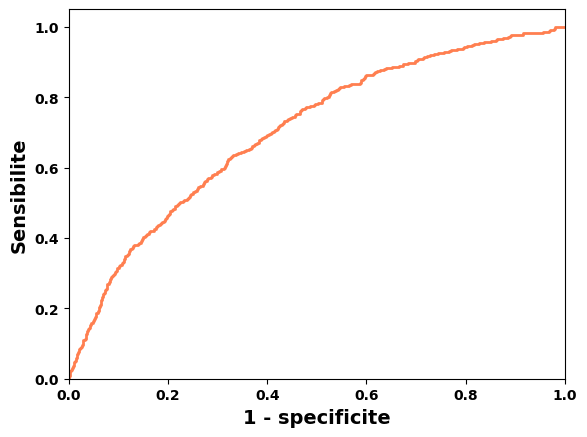

<IPython.core.display.Javascript object>

In [46]:
# Plot the ROC curve
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

## <a name="C4.4"> Features importance
    
Let's use SHAP to understand the features importance and explain the predictions

In [47]:
# Start date and time of the calculation
start = datetime.datetime.now()

# Create a sub-sample of data for Shap
sub_sampled_train_data = shap.sample(
    X_train, round((n_sample * (1 - test_size)) / 75), random_state=random_set
)
sub_sampled_test_data = shap.sample(
    X_test, round((n_sample * test_size) / 75), random_state=random_set
)
# Create the explainer object
explainer = shap.KernelExplainer(gs_final.predict_proba, sub_sampled_train_data)

# and calculate shap values
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(sub_sampled_test_data, l1_reg="aic")

# End of process
end = datetime.datetime.now()
print("start :", start.strftime("%Y-%m-%d %H:%M:%S"))
print("end :", end.strftime("%Y-%m-%d %H:%M:%S"))

Using 173 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/93 [00:00<?, ?it/s]

start : 2023-01-05 13:44:58
end : 2023-01-05 13:47:16


<IPython.core.display.Javascript object>

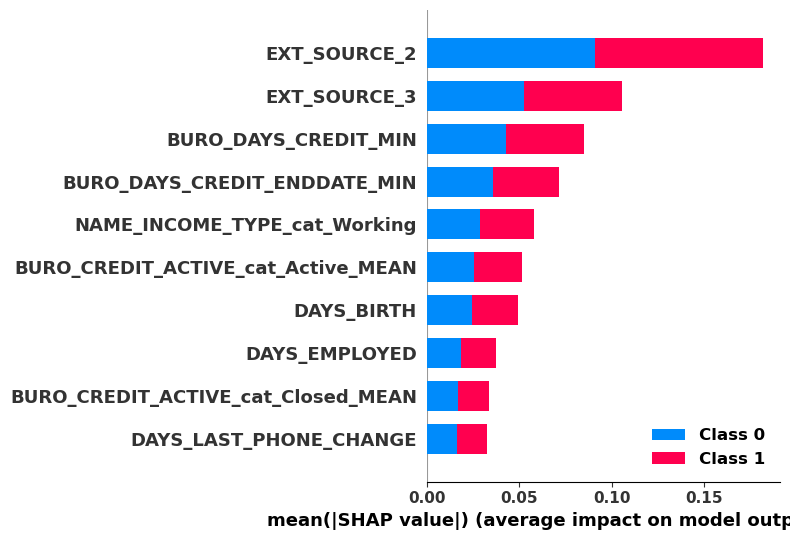

<IPython.core.display.Javascript object>

In [48]:
# Understand the most important features in general
shap.summary_plot(
    shap_values,
    sub_sampled_test_data,
    feature_names=features_analysis,
    max_display=max_features_display,
)

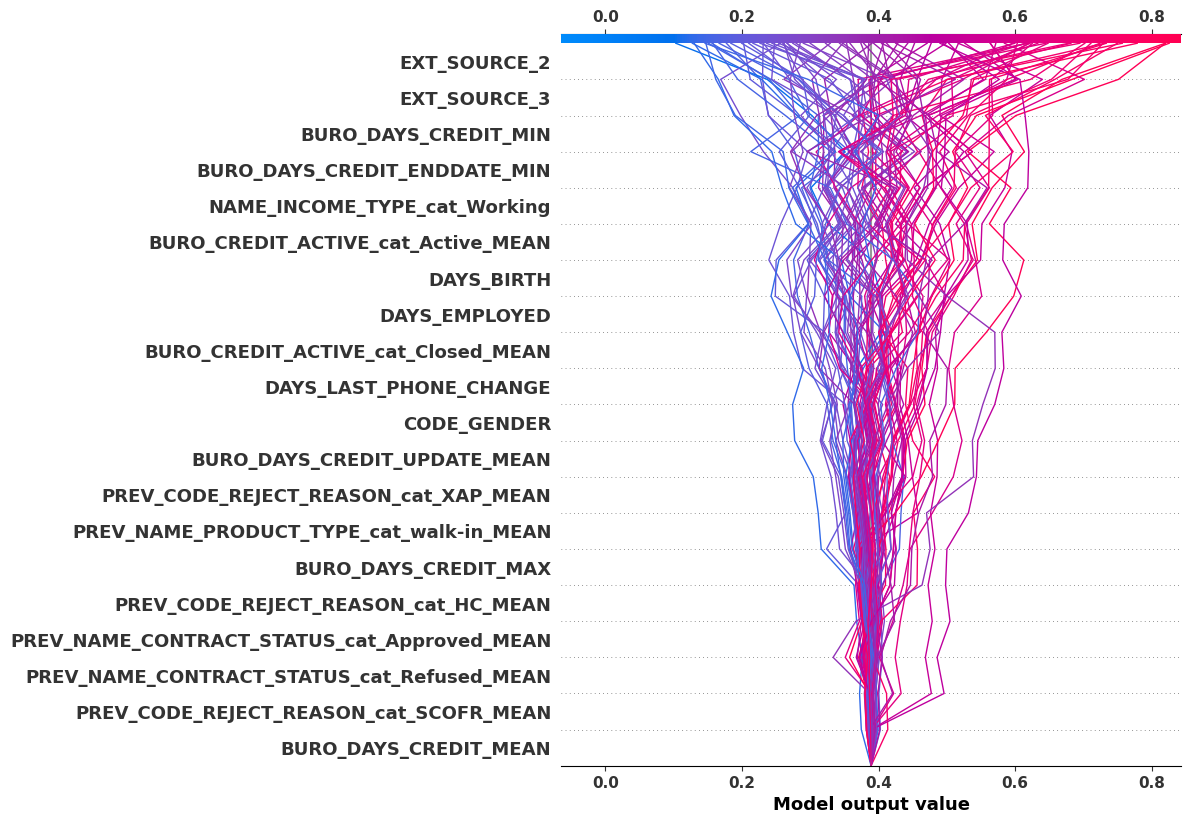

<IPython.core.display.Javascript object>

In [49]:
shap.decision_plot(
    explainer.expected_value[1], shap_values[1], feature_names=features_analysis
)

In [50]:
# Explain the prediction for an individual client
idx = 5

shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][idx],
    sub_sampled_test_data[0, :],
    feature_names=features_analysis,
)

<IPython.core.display.Javascript object>

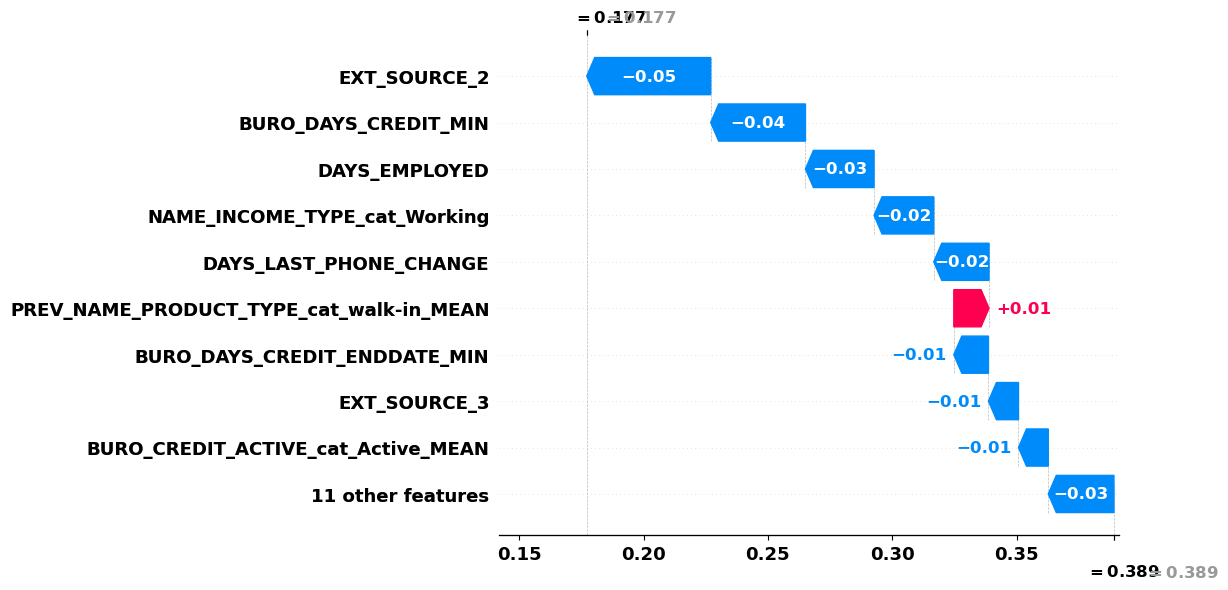

<IPython.core.display.Javascript object>

In [51]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],
    shap_values[1][idx],
    feature_names=features_analysis,
    max_display=max_features_display,
)

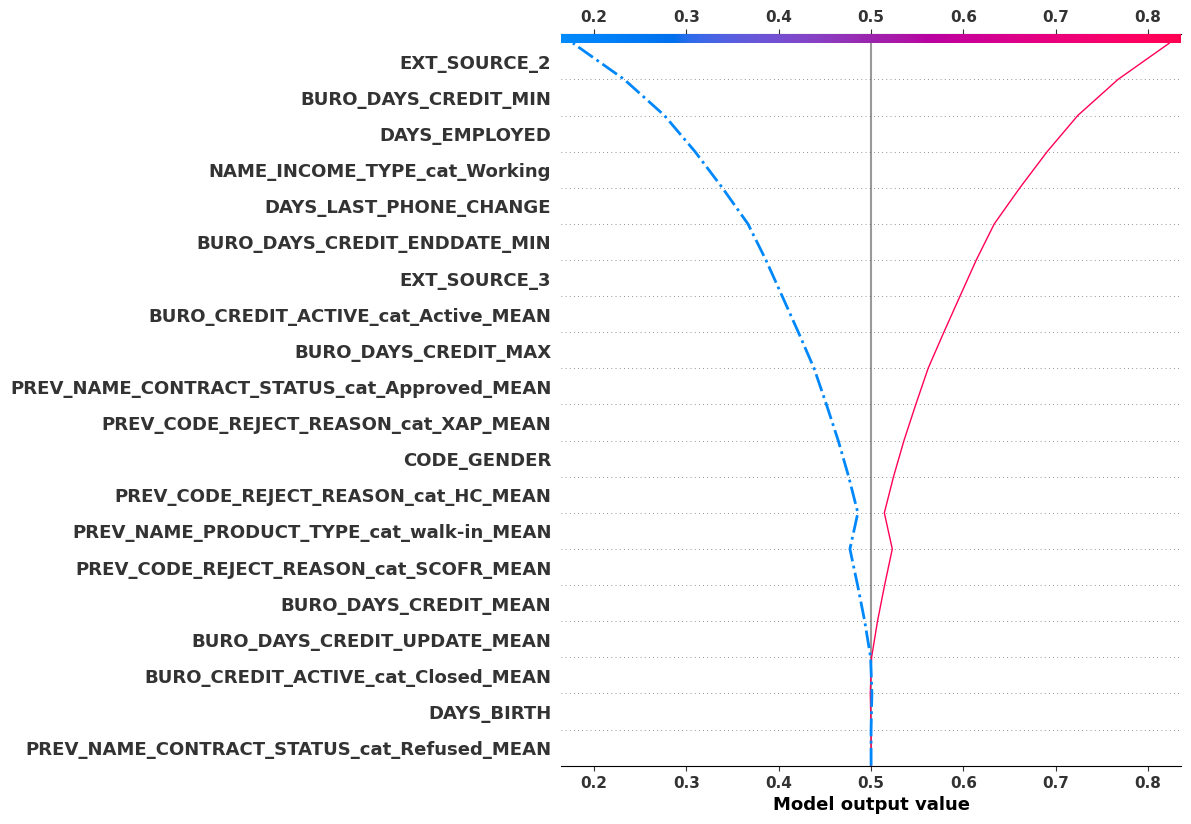

<IPython.core.display.Javascript object>

In [52]:
shap.multioutput_decision_plot(
    explainer.expected_value.tolist(),
    # explainer.shap_values(sub_sampled_test_data),
    shap_values,
    row_index=idx,
    feature_names=features_analysis,
    highlight=[1],
)

In [53]:
# Sort the feature by their importance thanks to thier shap values
df_shap_values = pd.DataFrame(data=shap_values[1], columns=X.columns)
df_feature_importance = pd.DataFrame(columns=["feature", "importance"])
for col in df_shap_values.columns:
    importance = df_shap_values[col].abs().mean()
    df_feature_importance.loc[len(df_feature_importance)] = [col, importance]
df_feature_importance = df_feature_importance.sort_values("importance", ascending=False)
df_feature_importance

,feature,importance
3,EXT_SOURCE_2,0.0909
4,EXT_SOURCE_3,0.0527
6,BURO_DAYS_CREDIT_MIN,0.0426
9,BURO_DAYS_CREDIT_ENDDATE_MIN,0.0358
11,NAME_INCOME_TYPE_cat_Working,0.0289
12,BURO_CREDIT_ACTIVE_cat_Active_MEAN,0.0257
1,DAYS_BIRTH,0.0247
2,DAYS_EMPLOYED,0.0187
13,BURO_CREDIT_ACTIVE_cat_Closed_MEAN,0.0167
5,DAYS_LAST_PHONE_CHANGE,0.0163


<IPython.core.display.Javascript object>

In [54]:
# List the 10 most important features
most_important_features = df_feature_importance["feature"].head(10)
most_important_features = list(most_important_features)
most_important_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'NAME_INCOME_TYPE_cat_Working',
 'BURO_CREDIT_ACTIVE_cat_Active_MEAN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'BURO_CREDIT_ACTIVE_cat_Closed_MEAN',
 'DAYS_LAST_PHONE_CHANGE']

<IPython.core.display.Javascript object>

In [55]:
# Export our model into a file (so we can use it in an API)
pickle.dump(gs_final, open("model.pkl", "wb"))

# Create a data sample for the dashboard
data_0 = data_final[data_final["TARGET"] == 0].sample(100, random_state=random_set)
data_1 = data_final[data_final["TARGET"] == 1].sample(100, random_state=random_set)
data = pd.concat([data_0, data_1])
sample_columns = ["SK_ID_CURR"] + features_analysis
data_sample = data[sample_columns]

# Export this data sample in a csv file
pd.DataFrame(data_sample).to_csv("data_sample.csv", index=False)

<IPython.core.display.Javascript object>

In [129]:
plot_columns = []
for col in data_sample.columns:
    if "_cat_" in col:
        plot_columns.append(col)
print(plot_columns)

['NAME_INCOME_TYPE_cat_Working', 'BURO_CREDIT_ACTIVE_cat_Active_MEAN', 'BURO_CREDIT_ACTIVE_cat_Closed_MEAN', 'PREV_NAME_CONTRACT_STATUS_cat_Approved_MEAN', 'PREV_NAME_CONTRACT_STATUS_cat_Refused_MEAN', 'PREV_CODE_REJECT_REASON_cat_HC_MEAN', 'PREV_CODE_REJECT_REASON_cat_SCOFR_MEAN', 'PREV_CODE_REJECT_REASON_cat_XAP_MEAN', 'PREV_NAME_PRODUCT_TYPE_cat_walk-in_MEAN']


<IPython.core.display.Javascript object>

In [131]:
plot_columns = []
for col in data_sample.columns:
    if len(data_sample[col].value_counts().index) == 2:
        if (np.sort(data_sample[col].value_counts().index).astype(int) == [0, 1]).all():
            plot_columns.append(col)

print(plot_columns)
client_index = data_sample["SK_ID_CURR"].sample(1).index

df_plot_cat = pd.DataFrame()

for col in plot_columns:
    df_plot_cat = pd.concat(
        [
            df_plot_cat,
            pd.DataFrame(data_sample[col].value_counts()).transpose(),
        ]
    )

df_plot_cat["categories"] = df_plot_cat.index
df_plot_cat = df_plot_cat[["categories", 0.0, 1.0]]
df_plot_cat = df_plot_cat.fillna(0)
df_plot_cat

['CODE_GENDER', 'NAME_INCOME_TYPE_cat_Working']


,categories,0.0,1.0
CODE_GENDER,CODE_GENDER,74,126
NAME_INCOME_TYPE_cat_Working,NAME_INCOME_TYPE_cat_Working,92,108


<IPython.core.display.Javascript object>

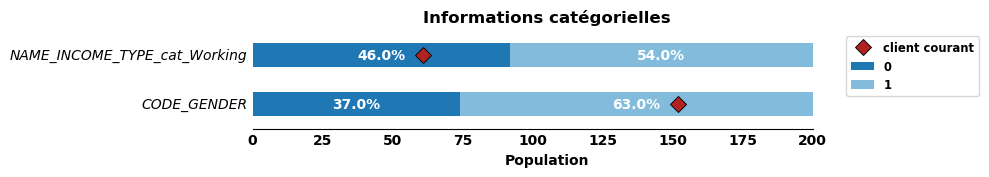

<IPython.core.display.Javascript object>

In [167]:
with plt.style.context("_mpl-gallery-nogrid"):
    # plot a Stacked Bar Chart using matplotlib
    ax = df_plot_cat.plot(
        x="categories",
        kind="barh",
        stacked=True,
        # title="Percentage Stacked Bar Graph",
        mark_right=True,
        grid=False,
        xlabel="",
        ylabel="population",
        figsize=(6, 0.5 * len(plot_columns)),
    )

    df_total = df_plot_cat[0.0] + df_plot_cat[1.0]
    df_rel = df_plot_cat[df_plot_cat.columns[1:]].div(df_total, 0) * 100

    for n in df_rel:
        for i, (cs, ab, pc) in enumerate(
            zip(df_plot_cat.iloc[:, 1:].cumsum(1)[n], df_plot_cat[n], df_rel[n])
        ):
            plt.text(
                cs - ab / 2,
                i,
                str(np.round(pc, 1)) + "%",
                va="center",
                ha="center",
                color="white",
            )

    comparison = []
    for col in plot_columns:
        total = len(data_sample[col])
        client_val = int(data_sample.loc[client_index, col])
        mask = data_sample[col] == client_val
        temp = data_sample[mask]
        count = temp[col].value_counts().values[0]
        comparison.append(client_val * (total - count) + count / 2 + 15)

    plt.plot(
        comparison,
        plot_columns,
        marker="D",
        color="firebrick",
        markersize=8,
        markeredgecolor="black",
        linestyle="None",
        markeredgewidth=0.66,
    )

    sns.despine(
        trim=True,
        left=True,
        bottom=False,
        top=True,
    )
    plt.legend(
        ncols=1,
        labels=["client courant", 0, 1],
        bbox_to_anchor=(1, 1),
        fontsize="small",
    )
    ax.set_yticklabels(
        plot_columns,
        fontdict={
            "fontsize": "medium",
            "fontstyle": "italic",
            "verticalalignment": "center",
            "horizontalalignment": "right",
        },
    )
    plt.title("Informations catégorielles")
    plt.xlabel("Population")
plt.show(ax)

In [122]:
plot_columns = []
for col in data_sample.columns:
    if len(data_sample[col].value_counts().index) == 2:
        if (np.sort(data_sample[col].value_counts().index).astype(int) == [0, 1]).all():
            plot_columns.append(col)

print(plot_columns)

['CODE_GENDER', 'NAME_INCOME_TYPE_cat_Working']


<IPython.core.display.Javascript object>

In [96]:
(np.sort(data_sample["CODE_GENDER"].value_counts().index).astype(int) == [0, 1]).all()

True

<IPython.core.display.Javascript object>

In [117]:
len(np.sort(data_sample["CODE_GENDER"].value_counts().index).astype(int))

2

<IPython.core.display.Javascript object>

In [118]:
np.sort(data_sample["CODE_GENDER"].value_counts().index).astype(int)[0]

0

<IPython.core.display.Javascript object>

In [119]:
np.sort(data_sample["CODE_GENDER"].value_counts().index).astype(int)[1]

1

<IPython.core.display.Javascript object>

In [123]:
for col in data_sample.columns:
    print(len(data_sample[col].value_counts()))

200
2
198
164
200
128
167
158
139
159
144
156
2
34
37
34
27
26
9
29
23


<IPython.core.display.Javascript object>